In [1]:
# standard
import pandas as pd
import numpy as np
import random
import os

# tf and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers

# sklearn
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

# plots
import seaborn as sns
import matplotlib.pyplot as plt

random.seed(2)
%matplotlib inline

In [2]:
import albumentations as A
from PIL import Image
from tqdm import tqdm
import dask.dataframe as dd

In [3]:
# Mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# File paths
BASE_PATH = '/content/drive/MyDrive/MIDS/Data 207/207 Final Project/Models/transformed_data'
splits = ['train', 'val', 'test']

# Paths to processed sub-image files
TRAIN_PATH = '/content/drive/MyDrive/MIDS/Data 207/207 Final Project/Models/sub_images/train_data.npz'
VAL_PATH = '/content/drive/MyDrive/MIDS/Data 207/207 Final Project/Models/sub_images/val_data.npz'
TEST_PATH = '/content/drive/MyDrive/MIDS/Data 207/207 Final Project/Models/sub_images/test_data.npz'

## Load images

In [5]:
# Training data
train_data = np.load(TRAIN_PATH)

X_train = train_data['images']
y_train = train_data['labels']

# Validation data
val_data = np.load(VAL_PATH)

X_val = val_data['images']
y_val = val_data['labels']

# Testing data
test_data = np.load(TEST_PATH)

X_test = test_data['images']
y_test = test_data['labels']


## EDA

In [6]:
# Shapes of each set
print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")


X_train shape (47700, 64, 64, 3)
y_train shape (47700,)
X_val shape (23900, 64, 64, 3)
y_val shape (23900,)
X_test shape (23900, 64, 64, 3)
y_test shape (23900,)


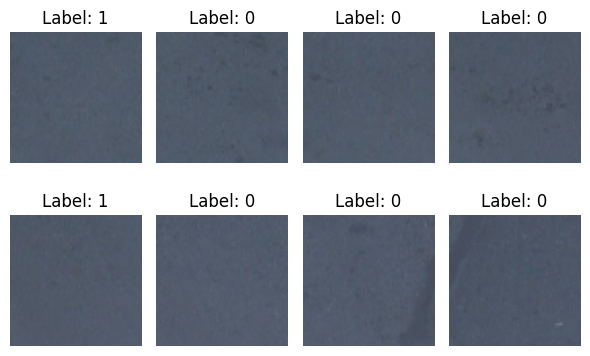

In [7]:
# Plot 8 random images from training
random_indices = np.random.choice(len(X_train), size=8, replace=False)

# Plot a few
plt.figure(figsize=(6,4))
for i, idx in enumerate(random_indices):
    plt.subplot(2, 4, i + 1)
    plt.imshow(X_train[i])
    plt.title(f"Label: {y_train[idx]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


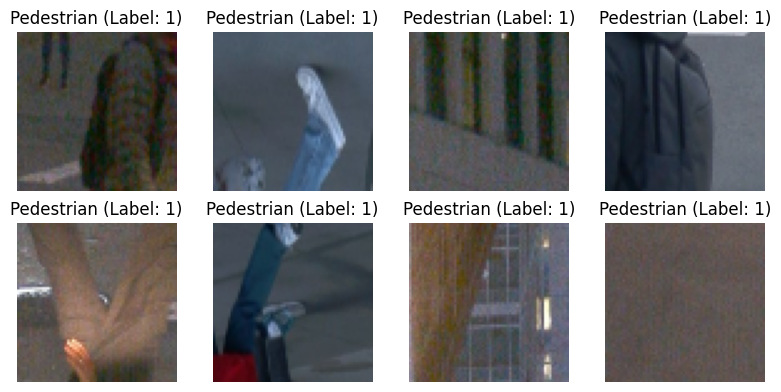

In [8]:
# Plot some images with pedestrians
# Get indices of pedestrian-labeled images
ped_indices = np.where(y_train == 1)[0]

# Sample randomly from positive examples
selected_indices = np.random.choice(ped_indices, size=8, replace=False)

# Plot
plt.figure(figsize=(8, 4))
for i, idx in enumerate(selected_indices):
    plt.subplot(2, 4, i + 1)
    plt.imshow(X_train[idx])
    plt.title(f"Pedestrian (Label: 1)")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [9]:
print("Train Set Class Breakdown")
print("--------------------------")
print(f"Total sub-images: {len(y_train)}")
print(f"Positive (pedestrian) labels: {np.sum(y_train)}")
print(f"Negative labels: {np.sum(y_train == 0)}")

Train Set Class Breakdown
--------------------------
Total sub-images: 47700
Positive (pedestrian) labels: 3828
Negative labels: 43872


In [10]:
print("Val Set Class Breakdown")
print("--------------------------")
print(f"Total sub-images: {len(y_val)}")
print(f"Positive (pedestrian) labels: {np.sum(y_val)}")
print(f"Negative labels: {np.sum(y_val == 0)}")

Val Set Class Breakdown
--------------------------
Total sub-images: 23900
Positive (pedestrian) labels: 1713
Negative labels: 22187


In [11]:
print("Test Set Class Breakdown")
print("--------------------------")
print(f"Total sub-images: {len(y_test)}")
print(f"Positive (pedestrian) labels: {np.sum(y_test)}")
print(f"Negative labels: {np.sum(y_test == 0)}")

Test Set Class Breakdown
--------------------------
Total sub-images: 23900
Positive (pedestrian) labels: 1858
Negative labels: 22042


## Data Preprocessing
Each set exhibits high class imbalance, so we manually resize each set.

In [12]:
# Combine training + validation
X_pool = np.concatenate([train_data["images"], val_data["images"]])
y_pool = np.concatenate([train_data["labels"], val_data["labels"]])

# Identify indices
pos_indices = np.where(y_pool == 1)[0]
neg_indices = np.where(y_pool == 0)[0]

# Keep all positives
X_pos = X_pool[pos_indices]
y_pos = y_pool[pos_indices]

# Downsample negatives to match (1:2 ratio)
num_pos = len(X_pos)
num_neg = num_pos * 2
neg_sampled_indices = np.random.choice(neg_indices, size=num_neg, replace=False)
X_neg = X_pool[neg_sampled_indices]
y_neg = y_pool[neg_sampled_indices]

# Combine balanced data
X_bal = np.concatenate([X_pos, X_neg])
y_bal = np.concatenate([y_pos, y_neg])

# Shuffle the balanced dataset
indices = np.arange(len(X_bal))
np.random.shuffle(indices)
X_bal = X_bal[indices]
y_bal = y_bal[indices]

# Split into 60% train, 20% val, 20% test (dev test)
n_total = len(X_bal)
n_train = int(0.6 * n_total)
n_val = int(0.2 * n_total)

X_train_new = X_bal[:n_train]
y_train_new = y_bal[:n_train]

X_val_new = X_bal[n_train:n_train + n_val]
y_val_new = y_bal[n_train:n_train + n_val]

X_devtest_new = X_bal[n_train + n_val:]
y_devtest_new = y_bal[n_train + n_val:]

# Rescale images
X_train_new = X_train_new / 255.0
X_val_new = X_val_new / 255.0
X_devtest_new = X_devtest_new / 255.0

# Also load original full test set for final evaluation (no changes)
X_test_final = test_data["images"]
y_test_final = test_data["labels"]
X_test_final = X_test_final / 255.0

In [13]:
print("Train Set Class Breakdown")
print("--------------------------")
print(f"Total sub-images: {len(y_train_new)}")
print(f"Positive (pedestrian) labels: {np.sum(y_train_new)}")
print(f"Negative labels: {np.sum(y_train_new == 0)}\n")

print("Val Set Class Breakdown")
print("--------------------------")
print(f"Total sub-images: {len(y_val_new)}")
print(f"Positive (pedestrian) labels: {np.sum(y_val_new)}")
print(f"Negative labels: {np.sum(y_val_new == 0)}\n")

print("Dev Test Set Class Breakdown")
print("--------------------------")
print(f"Total sub-images: {len(y_devtest_new)}")
print(f"Positive (pedestrian) labels: {np.sum(y_devtest_new)}")
print(f"Negative labels: {np.sum(y_devtest_new == 0)}")

Train Set Class Breakdown
--------------------------
Total sub-images: 9973
Positive (pedestrian) labels: 3329
Negative labels: 6644

Val Set Class Breakdown
--------------------------
Total sub-images: 3324
Positive (pedestrian) labels: 1107
Negative labels: 2217

Dev Test Set Class Breakdown
--------------------------
Total sub-images: 3326
Positive (pedestrian) labels: 1105
Negative labels: 2221


## Free up RAM
Delete original train and val sets

In [14]:
import gc

In [15]:
# Delete variables we don't need
del X_train, y_train, X_val, y_val
del X_pool, y_pool, pos_indices, neg_indices
del X_pos, y_pos, X_neg, y_neg
del X_bal, y_bal, indices, train_data, val_data, test_data
gc.collect()

30780

## Modeling

In [16]:
# define an instance of the early_stopping class
early_stopping = tf.keras.callbacks.EarlyStopping(
monitor='val_auc',
verbose=1,
patience=5,
mode='max',
restore_best_weights=True)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     8,388,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,408,257 (32.07 MB)

 Trainable params: 8,408,257 (32.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
312/312 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - accuracy: 0.6502 - auc: 0.5748 - loss: 1.1630 - val_accuracy: 0.6670 - val_auc: 0.7221 - val_loss: 0.5699
Epoch 2/25
312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.6742 - auc: 0.6819 - loss: 0.5874 - val_accuracy: 0.7004 - val_auc: 0.7604 - val_loss: 0.5375
Epoch 3/25
312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.6900 - auc: 0.7203 - loss: 0.5620 - val_accuracy: 0.6928 - val_auc: 0.7703 - val_loss: 0.5340
Epoch 4/25
312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7103 - auc: 0.7489 - loss: 0.5408 - val_accuracy: 0.7479 - val_auc: 0.7991 - val_loss: 0.5071
Epoch 5/25
312/312 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.7360 - auc: 0.7837 - loss: 0.5122 - val_accuracy: 0.7500 - val_auc: 0.8077 - val_loss: 0.5020
Epoch 6/25
312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7440 - auc: 0.7983 - loss: 0.4989 - val_accuracy: 0.7545 - val_auc: 0.8146 - val_loss: 0.4896
Epoch 7/25
312/312 ━━━━━━━━━━━━━━

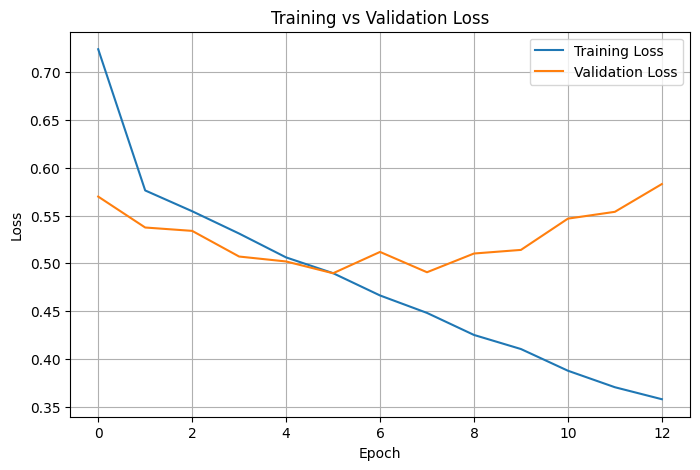

In [17]:
# Demonstrate similar model from assignment 10
tf.keras.backend.clear_session()
tf.random.set_seed(1234)
np.random.seed(1234)


model_tf = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=3, padding="same",
                           activation="relu", kernel_initializer="he_normal",
                           input_shape=(64, 64, 3)),
    tf.keras.layers.Conv2D(64, kernel_size=3, padding="same",
                           activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(128, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation="sigmoid")  # Binary classification
])

model_tf.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Nadam(),
    metrics=["accuracy", tf.keras.metrics.AUC(name='auc')]
)

model_tf.summary()
history = model_tf.fit(
    X_train_new, y_train_new,
    validation_data=(X_val_new, y_val_new),
    epochs=25,
    callbacks=[early_stopping],
)

# Plot loss curves
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


### Try upgrading the model architecture from class
Added more Conv2D + BatchNorm + ReLU blocks, more dropout layers, and L2 regularization.

In [27]:
class_weights_arr = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train_new),
    y=y_train_new
)

class_weights = dict(enumerate(class_weights_arr))
print("Class weights:", class_weights)

Class weights: {0: np.float64(0.750526791089705), 1: np.float64(1.4978972664463803)}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,163,745 (8.25 MB)

 Trainable params: 2,163,361 (8.25 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/25
312/312 ━━━━━━━━━━━━━━━━━━━━ 21s 38ms/step - accuracy: 0.5071 - auc: 0.5930 - loss: 1.4319 - val_accuracy: 0.4320 - val_auc: 0.4675 - val_loss: 1.6041
Epoch 2/25
312/312 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.5337 - auc: 0.6612 - loss: 0.8405 - val_accuracy: 0.7617 - val_auc: 0.7879 - val_loss: 0.7022
Epoch 3/25
312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.6410 - auc: 0.7385 - loss: 0.7635 - val_accuracy: 0.7289 - val_auc: 0.7469 - val_loss: 0.7921
Epoch 4/25
312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.6567 - auc: 0.7628 - loss: 0.7379 - val_accuracy: 0.6552 - val_auc: 0.8028 - val_loss: 0.6750
Epoch 5/25
312/312 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.6826 - auc: 0.7865 - loss: 0.6847 - val_accuracy: 0.6859 - val_auc: 0.8077 - val_loss: 0.6650
Epoch 6/25
312/312 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.6922 - auc: 0.8052 - loss: 0.6439 - val_accuracy: 0.4982 - val_auc: 0.7995 - val_loss: 0.9353
Epoch 7/25
312/312 ━━━━━━━━━━━━━━

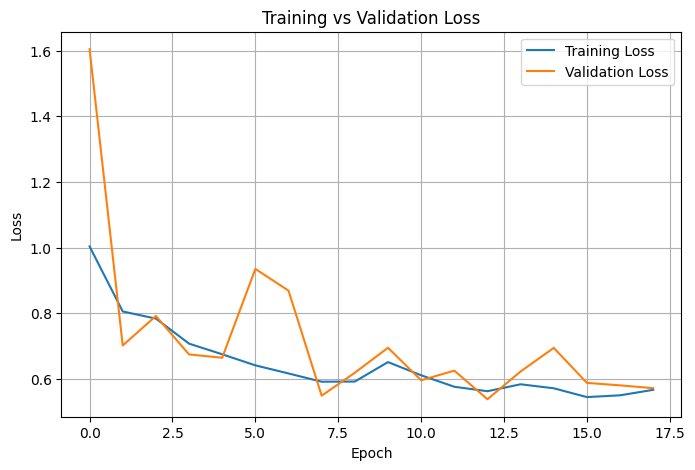

In [28]:
tf.keras.backend.clear_session()
tf.random.set_seed(1234)
np.random.seed(1234)


model_tf = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same', input_shape=(64, 64, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_tf.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Nadam(),
    metrics=["accuracy", tf.keras.metrics.AUC(name='auc')]
)

model_tf.summary()
history = model_tf.fit(
    X_train_new, y_train_new,
    validation_data=(X_val_new, y_val_new),
    epochs=25,
    callbacks=[early_stopping],
    class_weight=class_weights
)

# Plot loss curves
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


## Evaluation
Evaluate first with dev test set, then the full final test set.

In [29]:
# Evaluate with dev test set from 60/20/20 split
test_loss, test_accuracy, test_auc = model_tf.evaluate(X_devtest_new, y_devtest_new)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test AUC: {test_auc:.4f}")

104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8053 - auc: 0.8654 - loss: 0.5222
Test Loss: 0.5225
Test Accuracy: 0.8016
Test AUC: 0.8625


In [40]:
# Get predictions
y_probs = model_tf.predict(X_devtest_new).flatten()
y_pred = (y_probs > 0.5).astype(int)

# Classification report
print("Classification Report:")
print(classification_report(y_devtest_new, y_pred))

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      2221
           1       0.70      0.71      0.70      1105

    accuracy                           0.80      3326
   macro avg       0.78      0.78      0.78      3326
weighted avg       0.80      0.80      0.80      3326



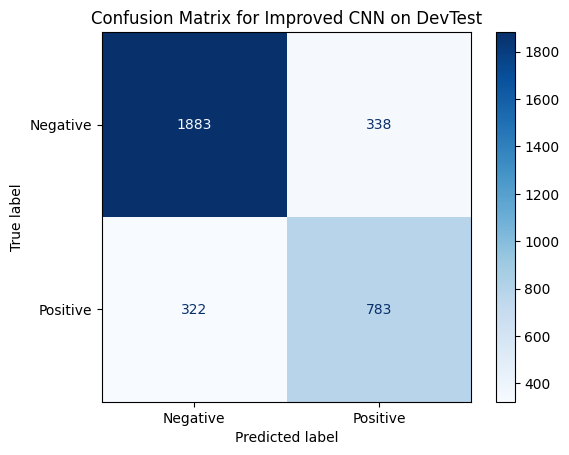

In [41]:
# Confusion matrix
cm = confusion_matrix(y_devtest_new, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix for Improved CNN on DevTest')
plt.show()

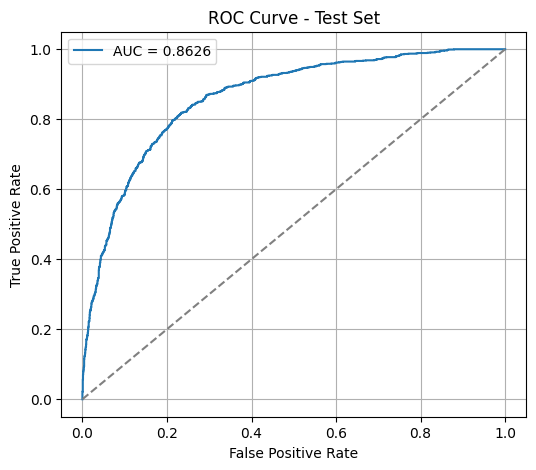

In [32]:
# ROC curve
fpr, tpr, _ = roc_curve(y_devtest_new, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Test Set")
plt.legend()
plt.grid(True)
plt.show()

## Evaluate with full test set

In [42]:
# Evaluate with full test set
test_loss, test_accuracy, test_auc = model_tf.evaluate(X_test_final, y_test_final)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test AUC: {test_auc:.4f}")

# Get predictions
y_probs = model_tf.predict(X_test_final).flatten()
y_pred = (y_probs > 0.5).astype(int)

# Classification report
print("Classification Report:")
print(classification_report(y_test_final, y_pred))

747/747 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8281 - auc: 0.8366 - loss: 0.4348
Test Loss: 0.4434
Test Accuracy: 0.8244
Test AUC: 0.8396
747/747 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.84      0.90     22042
           1       0.26      0.67      0.37      1858

    accuracy                           0.82     23900
   macro avg       0.61      0.75      0.63     23900
weighted avg       0.91      0.82      0.86     23900



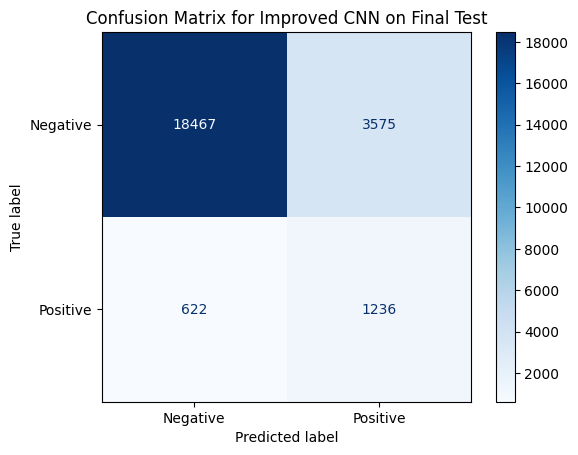

In [43]:
# Confusion matrix
cm = confusion_matrix(y_test_final, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix for Improved CNN on Final Test')
plt.show()

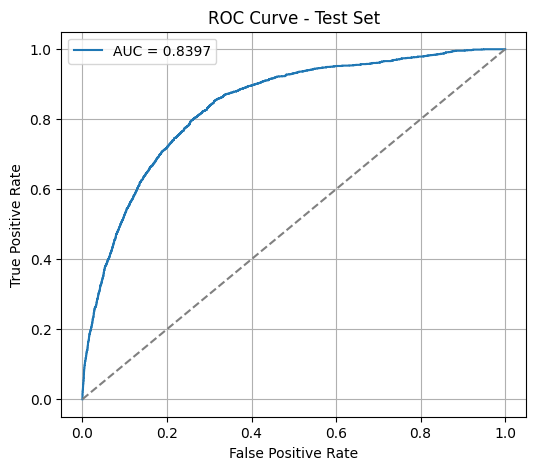

In [37]:
# ROC curve
fpr, tpr, _ = roc_curve(y_test_final, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Test Set")
plt.legend()
plt.grid(True)
plt.show()